In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm
import tensorflow as tf

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


In [2]:
# Directory path of image and mask dataset
IMAGE_PATH = 'drone/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = 'drone/dataset/semantic_drone_dataset/label_images_semantic/'

# 23 classes
n_classes = 23

In [3]:
# Create dataframe of image dataset
def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

In [4]:
# Data preprocessing
def preprocess_data(X, y, size):
    X_processed = []
    y_processed = []
    for i in tqdm(range(len(X))):
        img = cv2.imread(IMAGE_PATH + X[i] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(MASK_PATH + y[i] + '.png', 0)
        img = cv2.resize(img, size)
        mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
        X_processed.append(img.reshape(-1, 3))
        y_processed.append(mask.reshape(-1))
    X_processed = np.concatenate(X_processed, axis=0)
    y_processed = np.concatenate(y_processed, axis=0)
    return X_processed, y_processed

df = create_df()
print('Total Images : ', len(df))

Total Images :  400


In [5]:
# Split data into train & test set
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.3, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  238
Val Size     :  42
Test Size    :  120


In [6]:
# define the desired size of the resized images
size = (256, 256)

# Preprocess the data
X_train_processed, y_train_processed = preprocess_data(X_train, X_train, size)
X_val_processed, y_val_processed = preprocess_data(X_val, X_val, size)
X_test_processed, y_test_processed = preprocess_data(X_test, X_test, size)

  0%|          | 0/238 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, roc_curve
from keras.metrics import MeanIoU
from keras.utils import to_categorical
from keras import backend as K
import statistics
import seaborn as sns

def evaluateMask(true_mask, predicted_mask): 
    # Flatten the masks to 1D arrays
    true_mask = to_categorical(true_mask.flatten(), num_classes=23)
    predicted_mask = to_categorical(predicted_mask.flatten(), num_classes=23)
    
    # Mean Iou Score
    mean_iou = MeanIoU(num_classes=23)
    mean_iou.update_state(true_mask, predicted_mask)
    iou_score = mean_iou.result().numpy()
    
    # Confusion matrix
    cm = confusion_matrix(np.argmax(true_mask, axis=1), np.argmax(predicted_mask, axis=1), labels=range(23))
    
    # Calculate the metrics
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    tn = np.sum(cm) - (tp + fp + fn)

    sns.heatmap(cm, annot=True)

    precision = tp / (tp + fp)
    precision_mean = np.mean(np.nan_to_num(precision))
    recall = tp / (tp + fn)
    recall_mean = np.mean(np.nan_to_num(recall))
    accuracy = np.sum(tp) / np.sum(cm)
    f1_score = 2 * precision * recall / (precision + recall)
    f1_score_mean = np.mean(np.nan_to_num(f1_score))
    dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
    dice_coefficient_mean = np.mean(np.nan_to_num(dice_coefficient))
    
    # Print the results
    print("Classification Report:\n", classification_report(np.argmax(true_mask, axis=1), np.argmax(predicted_mask, axis=1)))
    print("Mean IoU score:", iou_score)
    print("Recall:", recall_mean)
    print("Precision:", precision_mean)
    print("Accuracy:", accuracy)
    print("F1 score:", f1_score_mean)
    print("Dice coefficient:", dice_coefficient_mean)

    # Plot the confusion matrix
    sns.heatmap(cm, xticklabels=['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7'
                                 , 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14'
                                 , 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 
                                 'P21', 'P22'], 
                yticklabels=['A0', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7'
                            , 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15'
                            , 'A16', 'A17', 'A18', 'A19', 'A20', 'A21', 'A22'],
    annot=True, fmt='d', annot_kws={'fontsize':6}, cmap="YlGnBu")

In [8]:
# Predict validation & test accuracy
def getAccuracy(model, X_val_processed):
    # predict on validation set and calculate accuracy
    y_val_pred = model.predict(X_val_processed)
    val_acc = accuracy_score(y_val_processed, y_val_pred)
    print("Validation Accuracy:", val_acc)
    
    # predict on test set and calculate accuracy
    y_test_pred = model.predict(X_test_processed)
    test_acc = accuracy_score(y_test_processed, y_test_pred)
    print("Test Accuracy:", test_acc)

In [9]:
# perform semantic segmentation on one of the images in the dataset
def predictMask(image_id):
    # image_id = '513'
    img = cv2.imread(IMAGE_PATH + image_id + '.jpg')
    # img = cv2.imread("btest2.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(MASK_PATH + image_id + '.png', 0)

    img_resized = cv2.resize(img, size)
    mask_resized = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)

    img_processed = img_resized.reshape(-1, 3)
    
    return img_processed

In [10]:
# Perform cross validation
from sklearn.model_selection import KFold, cross_val_score

def crossValidation(model, X_train_processed, y_train_processed, n_splits):
    # Create a KFold object to split the data into k-folds
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Compute the cross-validation scores
    cv_scores = cross_val_score(model, X_train_processed, y_train_processed, cv=kf, scoring='r2')

    # Compute the mean and standard deviation of the cross-validation scores
    mean_cv_score = cv_scores.mean()
    std_cv_score = cv_scores.std()

    print("k=",n_splits)
    print("Mean score: ", mean_cv_score)
    print("Standard deviation score: ", std_cv_score)

# Model 1 - Random Forest

In [11]:
# Train the random forest model
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, n_jobs = -1)
rf.fit(X_train_processed, y_train_processed)

#getAccuracy(rf, X_val_processed)
#crossValidation(rf, X_train_processed, y_train_processed, 5)

RandomForestClassifier(n_estimators=10, n_jobs=-1)

In [12]:
# Define the hyperparameter search space
param_dist = {
    'n_estimators': [50,100],
    'max_depth': [2,6,10],
    'min_samples_split': [10,20],
    'min_samples_leaf': [5,10],
    'max_features': Categorical(['auto', 'sqrt', 'log2']),
    'bootstrap': [True, False]
}

In [13]:
# Create a Bayesian optimization object
rfc_bayes = BayesSearchCV(
    estimator=rf,
    search_spaces=param_dist,
    n_iter=10,
    cv=2,
    random_state=42,
    n_jobs=-1
)

In [14]:
# Fit the Bayesian optimization object to the training data
rfc_bayes.fit(X_train_processed, y_train_processed)

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


BayesSearchCV(cv=2,
              estimator=RandomForestClassifier(n_estimators=10, n_jobs=-1),
              n_iter=10, n_jobs=-1, random_state=42,
              search_spaces={'bootstrap': [True, False],
                             'max_depth': [2, 6, 10],
                             'max_features': Categorical(categories=('auto', 'sqrt', 'log2'), prior=None),
                             'min_samples_leaf': [5, 10],
                             'min_samples_split': [10, 20],
                             'n_estimators': [50, 100]})

In [15]:
# print the best hyperparameters and corresponding score
print("Best Hyperparameters:", rfc_bayes.best_params_)
print("Best Score:", rfc_bayes.best_score_)

Best Hyperparameters: OrderedDict([('bootstrap', False), ('max_depth', 10), ('max_features', 'auto'), ('min_samples_leaf', 7), ('min_samples_split', 12), ('n_estimators', 73)])
Best Score: 0.5896312168666294


In [16]:
rfc = RandomForestClassifier(n_estimators=rfc_bayes.best_params_['n_estimators'],
                              max_features=rfc_bayes.best_params_['max_features'],
                              max_depth=rfc_bayes.best_params_['max_depth'],
                              min_samples_split=rfc_bayes.best_params_['min_samples_split'],
                              min_samples_leaf=rfc_bayes.best_params_['min_samples_leaf'],
                              bootstrap=rfc_bayes.best_params_['bootstrap'],
                              random_state=42,
                               n_jobs=-1)

In [17]:
rfc.fit(X_train_processed, y_train_processed)

getAccuracy(rfc, X_val_processed)

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Validation Accuracy: 0.5107817876906622
Test Accuracy: 0.5512318929036458


In [18]:
crossValidation(rfc, X_train_processed, y_train_processed, 5)
crossValidation(rfc, X_train_processed, y_train_processed, 7)
crossValidation(rfc, X_train_processed, y_train_processed, 9)

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this paramet

k= 5
Mean score:  0.38344600681748076
Standard deviation score:  0.0008920040912547651


c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this paramet

k= 7
Mean score:  0.38363296763996935
Standard deviation score:  0.0010594883167669993


c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this paramet

k= 9
Mean score:  0.3826814717577433
Standard deviation score:  0.000795262232260733


In [13]:
image_id = '584'
img = cv2.imread(IMAGE_PATH + image_id + '.jpg')
# img = cv2.imread("btest2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(MASK_PATH + image_id + '.png', 0)

img_resized = cv2.resize(img, size)
mask_resized = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)

img_processed = img_resized.reshape(-1, 3)

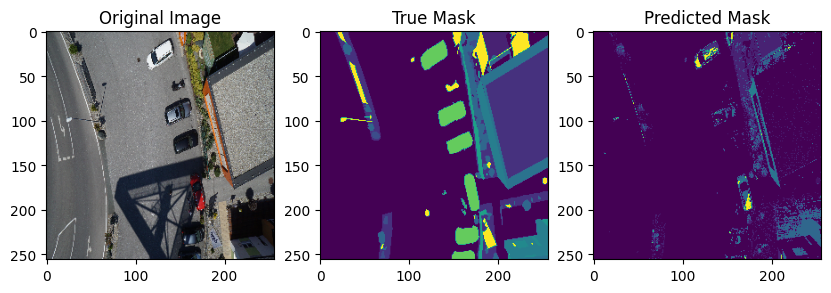

In [20]:
predicted_mask = rfc.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

In [21]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:31: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:33: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:36: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:38: RuntimeWarning: invalid value encountered in divide
  dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anaconda3\

Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.97      0.82     42609
           2       0.17      0.08      0.11       327
           3       0.17      0.88      0.28       704
           4       0.00      0.00      0.00      9985
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00       340
           7       0.00      0.00      0.00        22
           8       0.22      0.26      0.24      1984
           9       0.02      0.01      0.01      1883
          10       0.76      0.12      0.21      2036
          11       0.00      0.00      0.00       165
          12       0.00      0.00      0.00        56
          13       0.00      0.00      0.00       690
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        64
          16       0.00      0.00      0.00         5
          17       0.94      0.01      0.01      2751
   

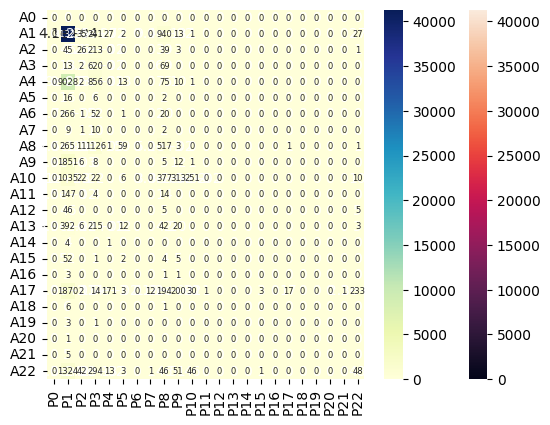

In [22]:
evaluateMask(mask_resized, predicted_mask)

# Model 2 - Decision Tree 

In [23]:
# train the decision tree model
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train_processed, y_train_processed)

#getAccuracy(dt, X_val_processed)
#crossValidation(dt, X_train_processed, y_train_processed, 5)

DecisionTreeClassifier()

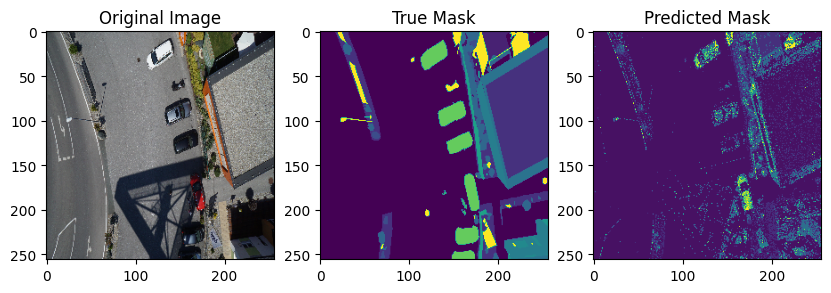

In [24]:
predicted_mask = dt.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

In [25]:
# Define the hyperparameter search space
param_dist = {
    'max_depth': [2,6,10],
    'min_samples_split': [10,20],
    'min_samples_leaf': [5,10],
    'max_features': Categorical(['auto', 'sqrt', 'log2'])
}

In [26]:
# Create a Bayesian optimization object
rfc_bayes = BayesSearchCV(
    estimator=dt,
    search_spaces=param_dist,
    n_iter=10,
    cv=2,
    random_state=42,
    n_jobs=-1
)

# Fit the Bayesian optimization object to the training data
rfc_bayes.fit(X_train_processed, y_train_processed)

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


BayesSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_iter=10, n_jobs=-1,
              random_state=42,
              search_spaces={'max_depth': [2, 6, 10],
                             'max_features': Categorical(categories=('auto', 'sqrt', 'log2'), prior=None),
                             'min_samples_leaf': [5, 10],
                             'min_samples_split': [10, 20]})

In [27]:
# print the best hyperparameters and corresponding score
print("Best Hyperparameters:", rfc_bayes.best_params_)
print("Best Score:", rfc_bayes.best_score_)

Best Hyperparameters: OrderedDict([('max_depth', 10), ('max_features', 'auto'), ('min_samples_leaf', 8), ('min_samples_split', 18)])
Best Score: 0.5729267537092962


In [28]:
dt = DecisionTreeClassifier(max_features=rfc_bayes.best_params_['max_features'],
                              max_depth=rfc_bayes.best_params_['max_depth'],
                              min_samples_split=rfc_bayes.best_params_['min_samples_split'],
                              min_samples_leaf=rfc_bayes.best_params_['min_samples_leaf'],
                              random_state=42,
                              )

In [29]:
dt.fit(X_train_processed, y_train_processed)

getAccuracy(dt, X_val_processed)

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


Validation Accuracy: 0.4943575177873884
Test Accuracy: 0.5215328216552735


In [30]:
crossValidation(dt, X_train_processed, y_train_processed, 5)
crossValidation(dt, X_train_processed, y_train_processed, 7)
crossValidation(dt, X_train_processed, y_train_processed, 9)

c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly 

k= 5
Mean score:  0.3679419529332697
Standard deviation score:  0.0052719381899370334


c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly 

k= 7
Mean score:  0.3625299261979901
Standard deviation score:  0.00401026813255103


c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\tree\_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly 

k= 9
Mean score:  0.3632475867501772
Standard deviation score:  0.00418190753229934


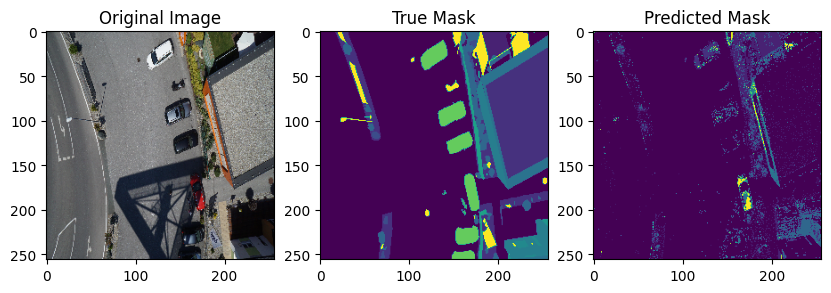

In [31]:
predicted_mask = dt.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:31: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:33: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:36: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:38: RuntimeWarning: invalid value encountered in divide
  dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anaconda3\

Classification Report:
               precision    recall  f1-score   support

           1       0.72      0.97      0.83     42609
           2       0.13      0.10      0.11       327
           3       0.16      0.86      0.26       704
           4       0.00      0.00      0.00      9985
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00       340
           7       0.00      0.00      0.00        22
           8       0.24      0.28      0.26      1984
           9       0.05      0.02      0.02      1883
          10       0.74      0.09      0.16      2036
          11       0.00      0.00      0.00       165
          12       0.00      0.00      0.00        56
          13       0.00      0.00      0.00       690
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        64
          16       0.00      0.00      0.00         5
          17       1.00      0.01      0.02      2751
   

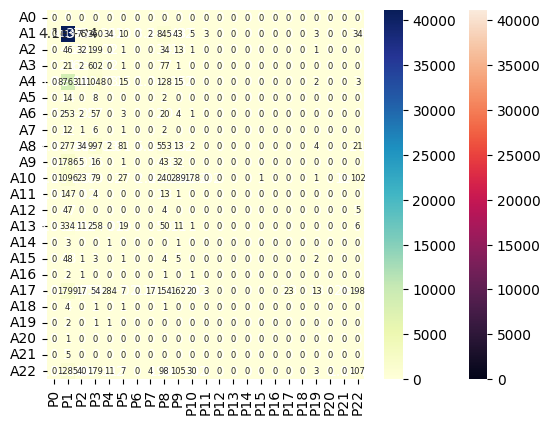

In [32]:
evaluateMask(mask_resized, predicted_mask)

# Model 3 - Naive Bayes

In [33]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_processed, y_train_processed)

#getAccuracy(nb, X_val_processed)
#crossValidation(nb, X_train_processed, y_train_processed, 5)

GaussianNB()

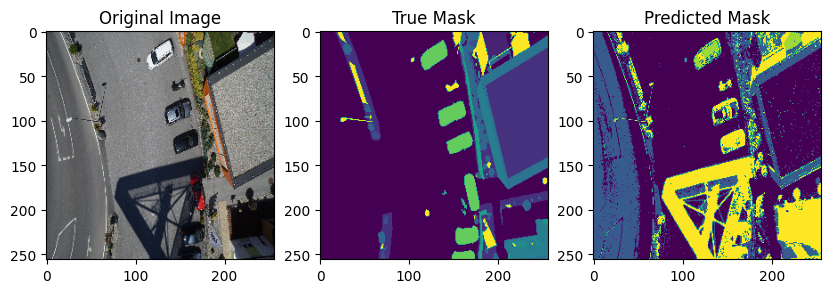

In [34]:
predicted_mask = nb.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

In [35]:
# Define the hyperparameter search space
param_dist = {
    'var_smoothing': Real(1e-10, 1e-6, prior='log-uniform')
}

In [36]:
# Create a Bayesian optimization object
rfc_bayes = BayesSearchCV(
    estimator=nb,
    search_spaces=param_dist,
    n_iter=10,
    cv=2,
    random_state=42,
    n_jobs=-1
)

# Fit the Bayesian optimization object to the training data
rfc_bayes.fit(X_train_processed, y_train_processed)

BayesSearchCV(cv=2, estimator=GaussianNB(), n_iter=10, n_jobs=-1,
              random_state=42,
              search_spaces={'var_smoothing': Real(low=1e-10, high=1e-06, prior='log-uniform', transform='normalize')})

In [37]:
# print the best hyperparameters and corresponding score
print("Best Hyperparameters:", rfc_bayes.best_params_)
print("Best Score:", rfc_bayes.best_score_)

Best Hyperparameters: OrderedDict([('var_smoothing', 4.36933994751032e-09)])
Best Score: 0.41628367960953916


In [38]:
nb = GaussianNB(var_smoothing=rfc_bayes.best_params_['var_smoothing'])

In [39]:
nb.fit(X_train_processed, y_train_processed)

getAccuracy(nb, X_val_processed)

Validation Accuracy: 0.3306764875139509
Test Accuracy: 0.39811719258626305


In [40]:
crossValidation(nb, X_train_processed, y_train_processed, 5)
crossValidation(nb, X_train_processed, y_train_processed, 7)
crossValidation(nb, X_train_processed, y_train_processed, 9)

k= 5
Mean score:  0.25671519214040606
Standard deviation score:  0.0006004485627815772
k= 7
Mean score:  0.25671037133357166
Standard deviation score:  0.0008074992772973084
k= 9
Mean score:  0.25671908351244443
Standard deviation score:  0.0007407253016998141


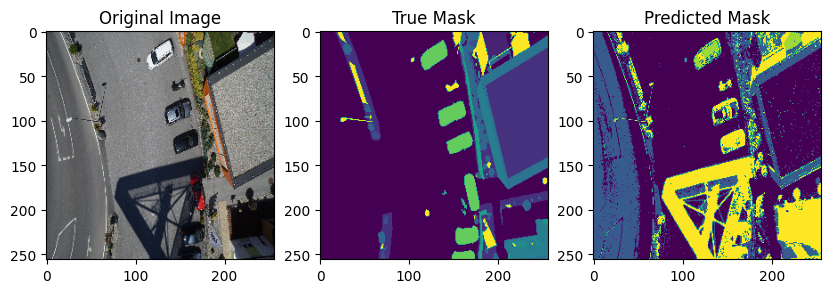

In [41]:
predicted_mask = nb.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:31: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:33: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:36: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:38: RuntimeWarning: invalid value encountered in divide
  dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anaconda3\

Classification Report:
               precision    recall  f1-score   support

           1       0.69      0.56      0.62     42609
           2       0.00      0.00      0.00       327
           3       0.02      0.54      0.04       704
           4       0.00      0.00      0.00      9985
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00       340
           7       0.00      0.00      0.00        22
           8       0.06      0.42      0.11      1984
           9       0.00      0.00      0.00      1883
          10       0.00      0.00      0.00      2036
          11       0.00      0.00      0.00       165
          12       0.00      0.00      0.00        56
          13       0.00      0.00      0.00       690
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        64
          16       0.00      0.00      0.00         5
          17       0.00      0.00      0.00      2751
   

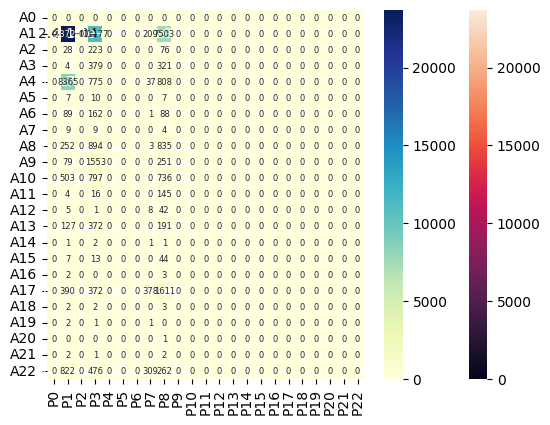

In [42]:
evaluateMask(mask_resized, predicted_mask)

# Model 4 - KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_jobs=-1)
knn.fit(X_train_processed, y_train_processed)

#getAccuracy(knn, X_val_processed)
#crossValidation(knn, X_train_processed, y_train_processed, 5)

KNeighborsClassifier(n_jobs=-1)

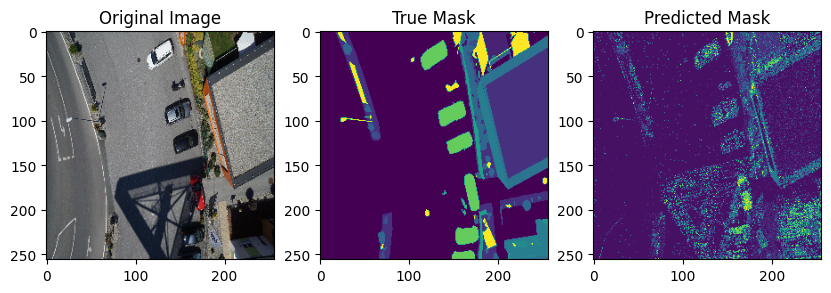

In [44]:
predicted_mask = knn.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

In [45]:
# Define the hyperparameter search space
param_dist = {
    'n_neighbors': [2,5,10],
    'weights': Categorical(['uniform', 'distance']),
    'p': Integer(1, 2)
}

In [46]:
# Create a Bayesian optimization object
rfc_bayes = BayesSearchCV(
    estimator=knn,
    search_spaces=param_dist,
    n_iter=10,
    cv=2,
    random_state=42,
    n_jobs=-1
)

# Fit the Bayesian optimization object to the training data
rfc_bayes.fit(X_train_processed, y_train_processed)

BayesSearchCV(cv=2, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=10,
              n_jobs=-1, random_state=42,
              search_spaces={'n_neighbors': [2, 5, 10],
                             'p': Integer(low=1, high=2, prior='uniform', transform='normalize'),
                             'weights': Categorical(categories=('uniform', 'distance'), prior=None)})

In [47]:
# print the best hyperparameters and corresponding score
print("Best Hyperparameters:", rfc_bayes.best_params_)
print("Best Score:", rfc_bayes.best_score_)

Best Hyperparameters: OrderedDict([('n_neighbors', 10), ('p', 1), ('weights', 'uniform')])
Best Score: 0.5785852640616793


In [48]:
knn = KNeighborsClassifier(n_neighbors=rfc_bayes.best_params_['n_neighbors'],
                           weights=rfc_bayes.best_params_['weights'],
                           p=rfc_bayes.best_params_['p'],
                            n_jobs=-1)

In [49]:
knn.fit(X_train_processed, y_train_processed)

getAccuracy(knn, X_val_processed)

Validation Accuracy: 0.5297833397274926
Test Accuracy: 0.5481829325358073


In [50]:
crossValidation(knn, X_train_processed, y_train_processed, 5)
crossValidation(knn, X_train_processed, y_train_processed, 7)
crossValidation(knn, X_train_processed, y_train_processed, 9)

k= 5
Mean score:  0.39658533261206885
Standard deviation score:  0.0012298954698898121
k= 7
Mean score:  0.3965290918924655
Standard deviation score:  0.0017607195791767964
k= 9
Mean score:  0.3956080578512354
Standard deviation score:  0.0010719473480986313


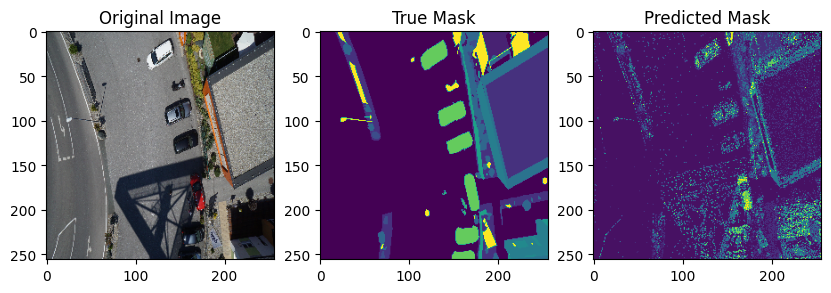

In [51]:
predicted_mask = knn.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:31: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:33: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_8588\417217286.py:36: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no tru

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.77      0.91      0.83     42609
           2       0.13      0.24      0.17       327
           3       0.14      0.81      0.24       704
           4       0.43      0.08      0.13      9985
           5       0.00      0.04      0.00        24
           6       0.08      0.00      0.01       340
           7       0.00      0.00      0.00        22
           8       0.41      0.33      0.37      1984
           9       0.28      0.47      0.35      1883
          10       0.48      0.15      0.23      2036
          11       0.01      0.01      0.01       165
          12       0.00      0.00      0.00        56
          13       0.42      0.02      0.04       690
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        64
          16       0.00      0.00      0.00         5
   

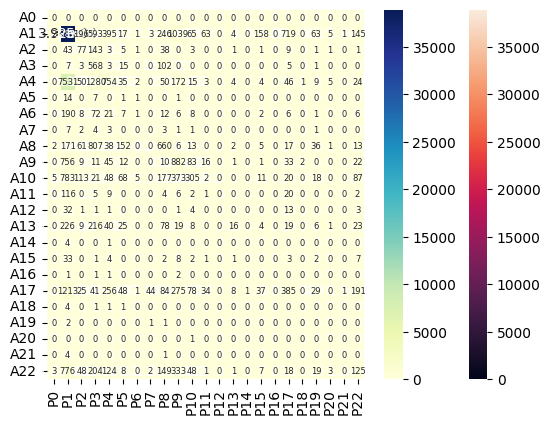

In [52]:
evaluateMask(mask_resized, predicted_mask)

# Model 5 - XGBClassifier 

In [11]:
from xgboost import XGBClassifier

xgbc = XGBClassifier(n_estimators=10, tree_method='gpu_hist')
xgbc.fit(X_train_processed, y_train_processed)

#getAccuracy(xgbc, X_val_processed)
#crossValidation(xgbc, X_train_processed, y_train_processed, 5)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

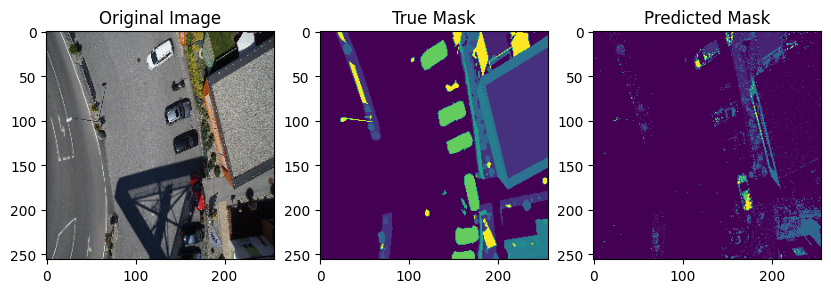

In [14]:
predicted_mask = xgbc.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

In [15]:
# Define the hyperparameter search space
param_dist = {
    'n_estimators': [50,100],
    'max_depth': [5,10],
    'colsample_bytree': Real(0.1, 1.0, prior='uniform'),
    'min_child_weight': [5,10,20],
    'gamma': Real(0, 10, prior='uniform')
}

In [16]:
# Create a Bayesian optimization object
rfc_bayes = BayesSearchCV(
    estimator=xgbc,
    search_spaces=param_dist,
    n_iter=10,
    cv=2,
    random_state=42,
    n_jobs=-1
)

# Fit the Bayesian optimization object to the training data
rfc_bayes.fit(X_train_processed, y_train_processed)

BayesSearchCV(cv=2,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                                      n_estimators=10, n_jobs=None,
                                      num_parallel_tree=None,
                                      objective='multi:softprob',
                                      predictor=None, ...),
              n_iter=10, n_jobs=-1, random_state=42,
              search_spaces={'colsample_bytree': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'gamma': Real(low=0, high=10, prior='uniform', transform='normalize'),
                             'max_depth': [5, 10],
                             'min_child_weight': [5, 10, 20],
                             'n_estimators': [50, 100]})

In [17]:
# print the best hyperparameters and corresponding score
print("Best Hyperparameters:", rfc_bayes.best_params_)
print("Best Score:", rfc_bayes.best_score_)

Best Hyperparameters: OrderedDict([('colsample_bytree', 0.8195980974464558), ('gamma', 4.380291864409234), ('max_depth', 8), ('min_child_weight', 10), ('n_estimators', 95)])
Best Score: 0.599170973320969


In [18]:
xgbc = XGBClassifier(n_estimators=rfc_bayes.best_params_['n_estimators'],
                           max_depth=rfc_bayes.best_params_['max_depth'],
                           colsample_bytree=rfc_bayes.best_params_['colsample_bytree'],
                           min_child_weight=rfc_bayes.best_params_['min_child_weight'],
                           gamma=rfc_bayes.best_params_['gamma'],
                            random_state=42,
                            tree_method='gpu_hist')

In [19]:
xgbc.fit(X_train_processed, y_train_processed)

getAccuracy(xgbc, X_val_processed)

Validation Accuracy: 0.5409422374906994
Test Accuracy: 0.5611012776692709


In [20]:
crossValidation(xgbc, X_train_processed, y_train_processed, 5)
crossValidation(xgbc, X_train_processed, y_train_processed, 7)
crossValidation(xgbc, X_train_processed, y_train_processed, 9)

k= 5
Mean score:  -0.035272446717898774
Standard deviation score:  0.0006188382891864364
k= 7
Mean score:  -0.03506814628729609
Standard deviation score:  0.0008533066709981887
k= 9
Mean score:  -0.03491547748495262
Standard deviation score:  0.001129443868811921


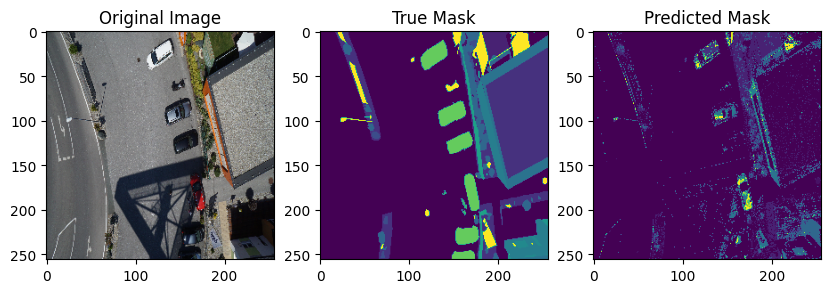

In [21]:
predicted_mask = xgbc.predict(img_processed)

predicted_mask = predicted_mask.reshape(256, 256)
img_resized = cv2.resize(img, (256, 256))
mask_resized = cv2.resize(mask, (256, 256))

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(img_resized)
ax[0].set_title('Original Image')
ax[1].imshow(mask_resized)
ax[1].set_title('True Mask')
ax[2].imshow(predicted_mask)
ax[2].set_title('Predicted Mask')
plt.show()

C:\Users\EzLaser\AppData\Local\Temp\ipykernel_10608\417217286.py:31: RuntimeWarning: invalid value encountered in divide
  precision = tp / (tp + fp)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_10608\417217286.py:33: RuntimeWarning: invalid value encountered in divide
  recall = tp / (tp + fn)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_10608\417217286.py:36: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * precision * recall / (precision + recall)
C:\Users\EzLaser\AppData\Local\Temp\ipykernel_10608\417217286.py:38: RuntimeWarning: invalid value encountered in divide
  dice_coefficient = (2 * tp) / (2 * tp + fp + fn)
c:\Users\EzLaser\anaconda3\envs\sohai\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\EzLaser\anacon

Classification Report:
               precision    recall  f1-score   support

           1       0.74      0.95      0.83     42609
           2       0.12      0.24      0.16       327
           3       0.15      0.86      0.25       704
           4       0.01      0.00      0.00      9985
           5       0.00      0.04      0.01        24
           6       0.00      0.00      0.00       340
           7       0.00      0.00      0.00        22
           8       0.29      0.28      0.29      1984
           9       0.23      0.23      0.23      1883
          10       0.60      0.12      0.20      2036
          11       0.00      0.00      0.00       165
          12       0.00      0.00      0.00        56
          13       0.00      0.00      0.00       690
          14       0.00      0.00      0.00         5
          15       0.00      0.00      0.00        64
          16       0.00      0.00      0.00         5
          17       0.93      0.04      0.08      2751
   

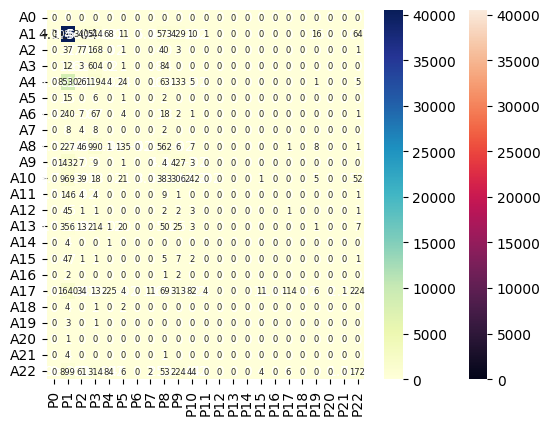

In [22]:
evaluateMask(mask_resized, predicted_mask)